In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import psutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input
from keras import backend as K

In [ ]:
SEED = 7
np.random.seed(SEED)
tf.random.set_seed(SEED)
IMG_DIM = 299  # 224
BATCH_SIZE = 8
CHANNEL_SIZE = 3
NUM_EPOCHS = 60
TRAIN_DIR = 'train1'
TEST_DIR = 'test1'
FREEZE_LAYERS = 2  # freeze the first this many layers for training
CLASSS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
NUM_CLASSS = 5

In [ ]:
ROOT_PATH = '/content/drive/MyDrive'
TRAIN_PATH = '/content/drive/MyDrive/' + TRAIN_DIR 
TEST_PATH = '/content/drive/MyDrive/' + TEST_DIR 
dir_path = ROOT_PATH + '/'

In [ ]:
# print names of train images
train_img_names = glob.glob(TRAIN_PATH)
#print(train_img_names)

df_train = pd.read_csv(ROOT_PATH + '/train.csv')
#print(df_train)

In [ ]:
# print names of test images
test_img_names = glob.glob(TEST_PATH + '/*.jpg')
#print(test_img_names)
df_test = pd.read_csv(ROOT_PATH + '/test_resnet.csv')
#print(df_test)

In [ ]:
def draw_img(imgs, target_dir, class_label='0'):
    for row in enumerate(imgs.iterrows()):
        name = row[1][1]['id_code']
        print(name)
        plt.figure(figsize=(15,10))
        img = plt.imread(dir_path + target_dir + '/' + name)
        plt.imshow(img)
        plt.title(class_label)
        plt.show()
        del img
        gc.collect

1166.jpg


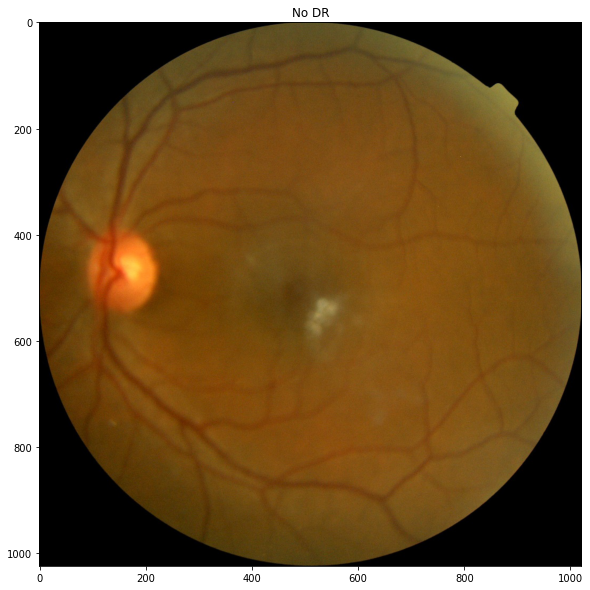

In [ ]:
CLASS_ID = 0
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train1', CLASSS[CLASS_ID])

3561.jpg


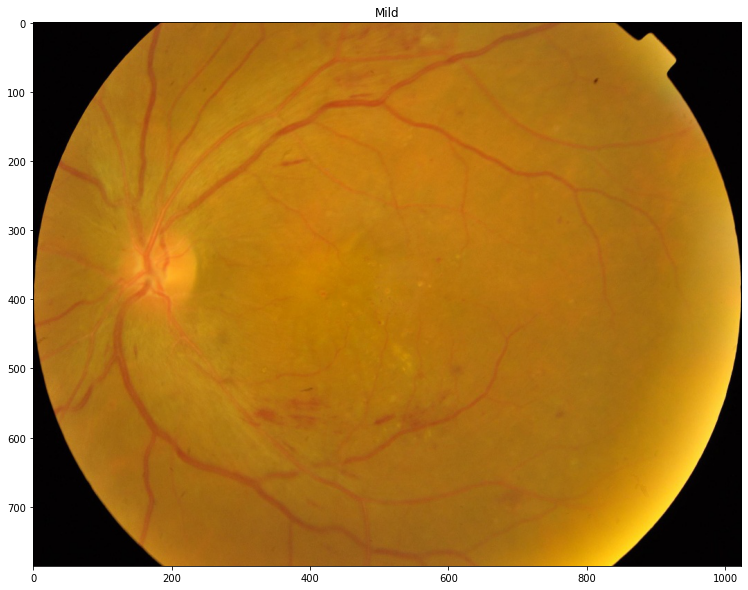

In [ ]:
CLASS_ID = 1
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train1', CLASSS[CLASS_ID])

3343.jpg


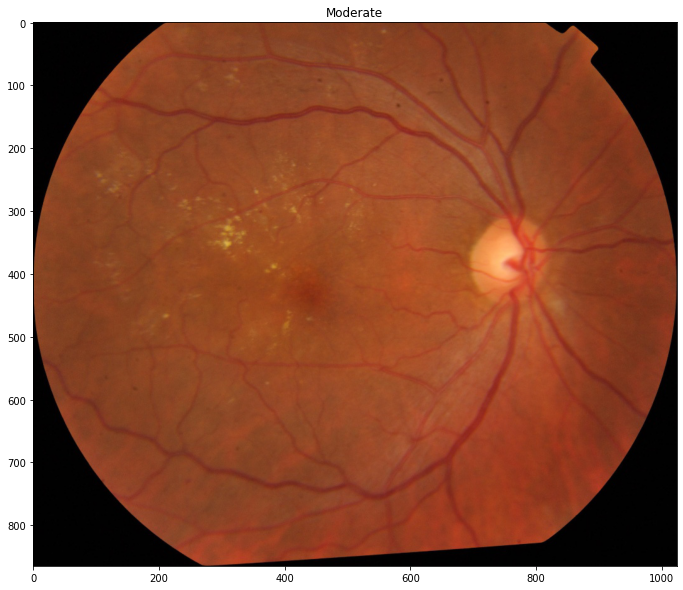

In [ ]:
CLASS_ID = 2
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train1', CLASSS[CLASS_ID])

2227.jpg


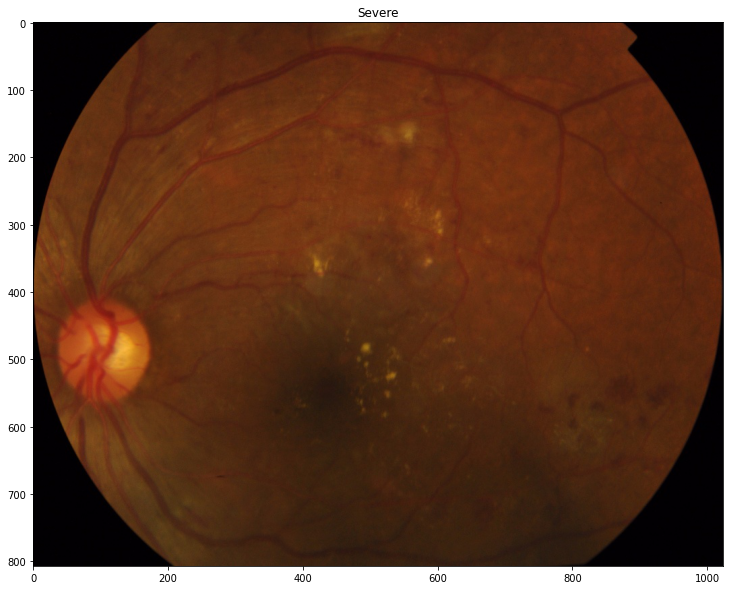

In [ ]:
CLASS_ID = 3
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train1', CLASSS[CLASS_ID])

1098.jpg


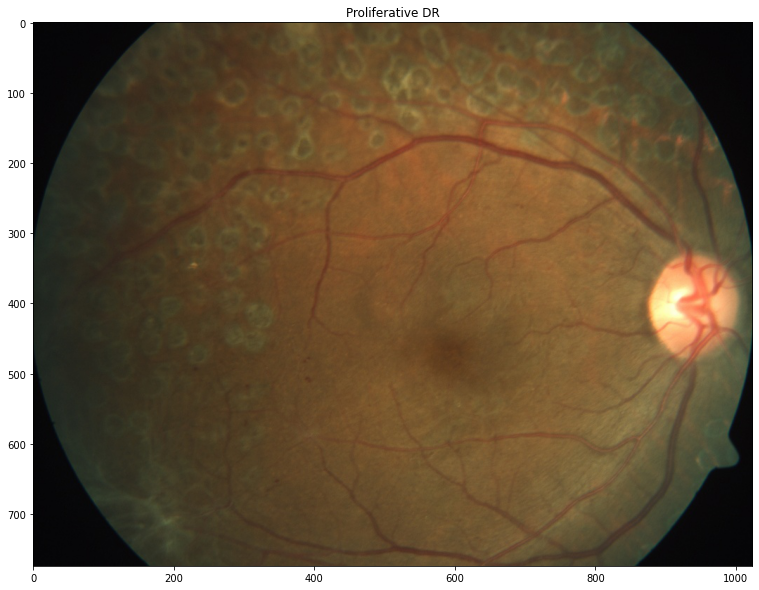

In [ ]:
# Showing the class 4 image randomly
CLASS_ID = 4
draw_img(df_train[df_train.diagnosis == CLASS_ID].sample(n=1), 'train1', CLASSS[CLASS_ID])

In [ ]:
gc.collect()

12387

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2,
                                                    random_state=SEED, stratify=df_train.diagnosis)

In [ ]:
input_tensor = Input(shape = (299, 299, 3))

# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False, input_tensor=input_tensor)
base_model.load_weights('/content/drive/MyDrive/Colab Notebooks/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# add a global spatial average pooling layer
x = base_model.output
output = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(NUM_CLASSS, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

for layer in model.layers:
    layer.trainable = True
    
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:

df_train.id_code = df_train.id_code.apply(lambda x: x )
df_test.id_code = df_test.id_code.apply(lambda x: x + ".jpg")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

In [ ]:
# Data Generator
train_datagen = image.ImageDataGenerator(rescale=1. / 255, validation_split=0.15, horizontal_flip=True,
                                         vertical_flip=True, rotation_range=360, zoom_range=0.2, shear_range=0.1)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory= TRAIN_PATH + '/',
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shaffle=True,
                                                    seed=SEED
                                                    )
valid_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory= TRAIN_PATH + '/',
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shaffle=True,
                                                    seed=SEED
                                                    )
#del x_train
#del x_train
# # del x_test
#del y_train
# del y_test
gc.collect()
#  color_mode= "grayscale",

Found 2803 validated image filenames belonging to 5 classes.
Found 494 validated image filenames belonging to 5 classes.


761

In [ ]:
NUB_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUB_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(350, 61)

In [ ]:
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

In [ ]:
#from keras import models  
#model=models.load_model('/content/drive/MyDrive/inceptionv3.h5')

In [ ]:
history = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=NUB_TRAIN_STEPS,
                                     validation_data=valid_generator,
                                     validation_steps=NUB_VALID_STEPS,
                                     epochs=NUM_EPOCHS,
                                     #                            shuffle=True,  
                                     callbacks=[eraly_stop, reduce_lr],
                                     verbose=1)
gc.collect()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
350/350 [==============================] - 1197s 3s/step - loss: 1.0973 - accuracy: 0.6296 - val_loss: 0.8613 - val_accuracy: 0.7213
Epoch 2/60
350/350 [==============================] - 108s 308ms/step - loss: 0.7064 - accuracy: 0.7533 - val_loss: 0.9341 - val_accuracy: 0.6742
Epoch 3/60
350/350 [==============================] - 108s 308ms/step - loss: 0.6026 - accuracy: 0.7748 - val_loss: 0.6015 - val_accuracy: 0.7664
Epoch 4/60
350/350 [==============================] - 109s 311ms/step - loss: 0.5851 - accuracy: 0.7709 - val_loss: 0.6918 - val_accuracy: 0.7787
Epoch 5/60
350/350 [==============================] - 108s 308ms/step - loss: 0.5517 - accuracy: 0.7835 - val_loss: 0.7114 - val_accuracy: 0.7459

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 6/60
350/350 [==============================] - 108s 309ms/step - loss: 0.5128 - accuracy: 0.7968 - val_loss: 0.4776 - val_accuracy: 0.8197
Epoch 7/60
350/350 [=========================

161

In [ ]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy) = tqdm(
    model.evaluate_generator(generator=valid_generator, steps=NUB_VALID_STEPS))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
100%|██████████| 2/2 [00:00<00:00, 818.40it/s]

[INFO] accuracy: 84.02%
[INFO] Loss: 0.44353723526000977


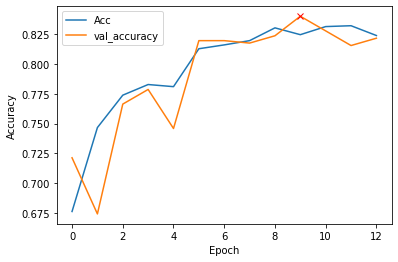

In [ ]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_accuracy'])
plt.plot(np.argmax(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="x", color="r",
         label="best model")
plt.show()

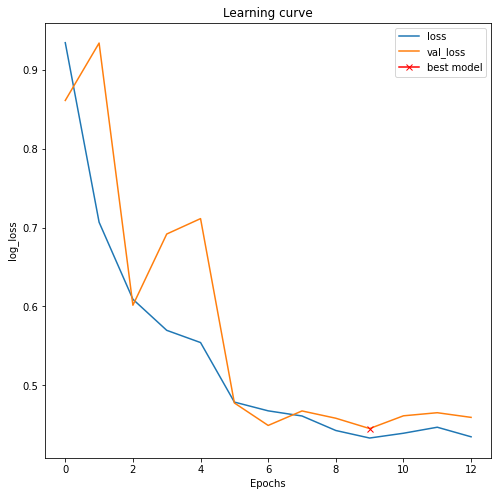

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
model.save('/content/drive/MyDrive/inceptionv3.h5')

In [ ]:
test_datagen = image.ImageDataGenerator(rescale=1. / 255, validation_split=0.2, horizontal_flip=True)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory= TEST_PATH  + '/',
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  seed=SEED)
# del df_test
print(df_test.shape[0])
# del train_datagen
# del traabsin_generator
gc.collect()

Found 1928 validated image filenames.
1928


5863

In [ ]:
tta_steps = 5
preds_tta = []
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model.predict_generator(generator=test_generator, steps=ceil(df_test.shape[0]))
    #     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████| 5/5 [11:47<00:00, 141.41s/it]


In [ ]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
len(predicted_class_indices)

1928

In [ ]:
results = pd.DataFrame({"id_code": test_generator.filenames, "diagnosis": predicted_class_indices})
results.id_code = results.id_code.apply(lambda x: x[:-4])  # results.head()
results.to_csv("submission.csv", index=False)

In [ ]:
print(results.head(20))

         id_code  diagnosis
0   0005cfc8afb6          1
1   003f0afdcd15          2
2   006efc72b638          4
3   00836aaacf06          2
4   009245722fa4          2
5   009c019a7309          2
6   010d915e229a          3
7   0111b949947e          1
8   01499815e469          3
9   0167076e7089          0
10  01c31b10ab99          1
11  01c5ba195207          2
12  01e4d86b3a30          1
13  020921b796d5          2
14  020f6983114d          2
15  021c207614d6          1
16  0229c0a80d42          2
17  024d0a225db1          2
18  0268f4382c67          4
19  0299d97f31f7          0


In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")
test_data["filename"] = test_data["id_code"].map(lambda x:str(x)+".jpg")
test_data.head()

,id_code,filename
0,366,366.jpg
1,367,367.jpg
2,368,368.jpg
3,369,369.jpg
4,370,370.jpg


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(  
        dataframe=test_data,
        directory = "/content/drive/MyDrive/predict",    
        x_col="filename",
        y_col=None,
        target_size = (224,224),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 11 validated image filenames.


In [ ]:
predictions = model.predict_generator(test_generator, steps = len(test_generator.filenames))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(predictions,axis=1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission1.csv",index=False)

In [ ]:
res_data=pd.read_csv("/content/submission1.csv")
res_data.head(11)

,id_code,diagnosis
0,366,0
1,367,2
2,368,2
3,369,4
4,370,0
5,371,0
6,381,3
7,382,0
8,383,0
9,384,0
